# **Cloning the repository**

In [1]:
!git clone https://github.com/naina-bhalla/PIXEL_PERSONA.git

fatal: destination path 'PIXEL_PERSONA' already exists and is not an empty directory.


In [2]:
%ls

B99.jpg                               haarcascade_frontalface_alt.xml      HP.jpg
friends.jpg                           haarcascade_frontalface_default.xml  photo.jpg
haarcascade_eye_tree_eyeglasses.xml   haarcascade_fullbody.xml             PIXEL_PERSONA/
haarcascade_eye.xml                   haarcascade_profileface.xml          sample_data/
haarcascade_frontalface_alt2.xml      haarcascade_smile.xml
haarcascade_frontalface_alt_tree.xml  haarcascade_upperbody.xml


# **Importing libraries and loading data into dataframe**

In [4]:
import tensorflow as tf
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
import pandas as pd
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Flatten,Dropout, Conv2D, MaxPooling2D,Activation,BatchNormalization

In [5]:
import os
import zipfile
dataset_path = "/content/PIXEL_PERSONA/Final_assignment/240674_NainaBhalla/Dataset/dataset.zip"
extracted_dir = "/content/PIXEL_PERSONA/Final_assignment/240674_NainaBhalla/Dataset/dataset"  # Directory to extract to

with zipfile.ZipFile(dataset_path, 'r') as zip_ref:
    zip_ref.extractall(extracted_dir)

# Update dataset path to the extracted directory
dataset_path = os.path.join(extracted_dir, 'dataset')
train_dir = os.path.join(dataset_path, 'train')
test_dir = os.path.join(dataset_path, 'test')
validation_dir = os.path.join(dataset_path, 'validation')

**Adding labels to images in the datasets**

In [7]:
from glob import glob
train_df = pd.DataFrame({"path":[],"label":[]}) #dataframe for training data
label_list = ['Male','Female',]

for i, label in enumerate(label_list):
    img_path = os.path.join(train_dir, label)
    img_list = glob(img_path+'/*.jpg')
    for img in img_list:
        new_data =pd.DataFrame({"path":img,"label":label}, index=[1])
        train_df = pd.concat([train_df, new_data], ignore_index=True)   #adding each image with its label to the dataframe

train_df[["path"]] = train_df[["path"]].astype(str)
train_df[["label"]] = train_df[["label"]].astype(str)

test_df=pd.DataFrame({"path":[],"label":[]})  #dataframe for testing data
for i, label in enumerate(label_list):
    img_path = os.path.join(test_dir, label)
    img_list = glob(img_path+'/*.jpg')
    for img in img_list:
        new_data =pd.DataFrame({"path":img,"label":label}, index=[1])
        test_df = pd.concat([test_df, new_data], ignore_index=True)

test_df[["path"]] = test_df[["path"]].astype(str)
test_df[["label"]] = test_df[["label"]].astype(str)

val_df=pd.DataFrame({"path":[],"label":[]})  #dataframe for validation data
for i, label in enumerate(label_list):
    img_path = os.path.join(validation_dir, label)
    img_list = glob(img_path+'/*.jpg')
    for img in img_list:
        new_data =pd.DataFrame({"path":img,"label":label}, index=[1])
        val_df = pd.concat([val_df, new_data], ignore_index=True)

val_df[["path"]] = val_df[["path"]].astype(str)
val_df[["label"]] = val_df[["label"]].astype(str)


# **Overview of training data**

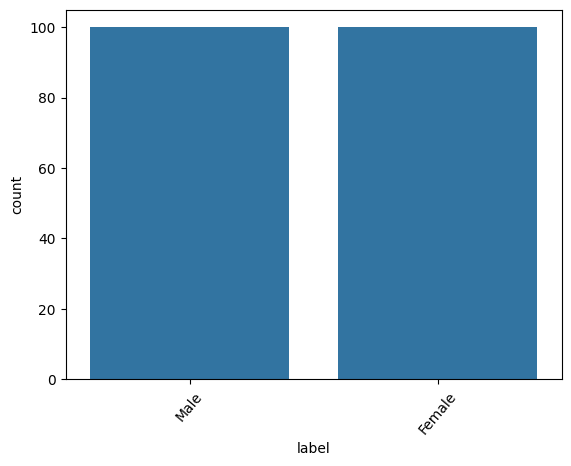

In [8]:
#ratio of males and females in the training data
sns.countplot(x = val_df["label"])
plt.xticks(rotation = 50);

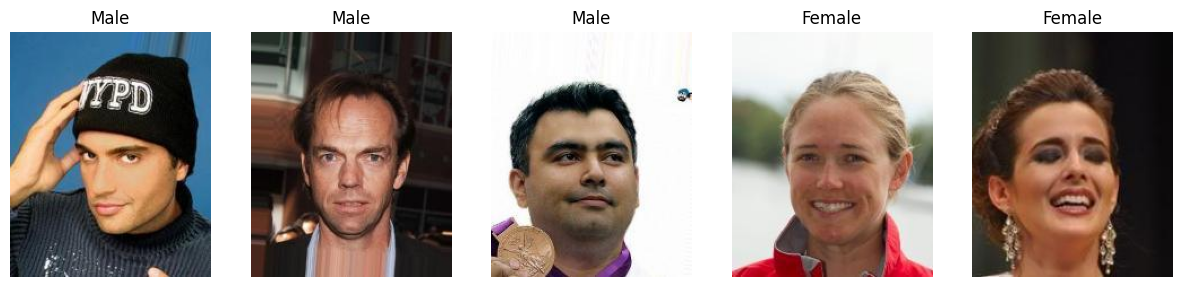

In [10]:
# visualization of some data in the training dataset
show_imgs = 5
idx = np.random.randint(0, len(val_df),size=show_imgs)
fig, axes = plt.subplots(show_imgs//5, 5, figsize=(15,10))
axes = axes.flatten()
for i, ax in enumerate(axes):
    full_path = val_df.loc[idx[i]]['path']
    ax.imshow(plt.imread(full_path))
    ax.set_title(val_df.loc[idx[i]]['label'])
    ax.set_axis_off()

In [11]:
train_df.head()

,path,label
0,/content/PIXEL_PERSONA/Final_assignment/240674...,Male
1,/content/PIXEL_PERSONA/Final_assignment/240674...,Male
2,/content/PIXEL_PERSONA/Final_assignment/240674...,Male
3,/content/PIXEL_PERSONA/Final_assignment/240674...,Male
4,/content/PIXEL_PERSONA/Final_assignment/240674...,Male


In [12]:
# storing in X_train and y_train
X_train = train_df['path']
y_train = train_df['label']
X_test = test_df['path']
y_test = test_df['label']
X_val = val_df['path']
y_val = val_df['label']

# **Encoding and pre-processing the data**

In [13]:
import tensorflow as tf
import numpy as np
from tensorflow.keras.preprocessing.image import load_img, img_to_array

# Function to load and preprocess images
def preprocess(image_paths):
    images = []
    for path in image_paths:
        img = load_img(path, target_size=(96,96))  # Load image with target size
        img_array = img_to_array(img)  # Convert image to NumPy array
        img_array = img_array / 255.0  # Normalize pixel values
        images.append(img_array)
    return np.array(images)

# Load and preprocess training ,validation and testing data
X_train_processed = preprocess(X_train)
X_val_processed = preprocess(X_val)
X_test_processed = preprocess(X_test)

In [14]:
#generates augmented data so the model does not memorize the training data exactly
from tensorflow.keras.preprocessing.image import ImageDataGenerator
datagen = ImageDataGenerator(
    rotation_range=20,
    width_shift_range=0.2,
    height_shift_range=0.2,
    shear_range=0.2,
    zoom_range=0.2,
    horizontal_flip=True
)
datagen.fit(X_train_processed)

In [15]:
#encoding the gender labelss with LabelEncoder
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
y_train_encoded = label_encoder.fit_transform(y_train)
y_val_encoded = label_encoder.fit_transform(y_val)
y_test_encoded = label_encoder.fit_transform(y_test)

# **Defining the model**

In [22]:
model=keras.Sequential([
    Conv2D(filters=64,kernel_size=3,input_shape=(96,96,3),padding="same",activation='relu'),
    MaxPooling2D(pool_size=2),
    Dropout(0.3),

    Conv2D(filters=128,kernel_size=3,padding="same",activation='relu'),
    #Conv2D(filters=64,kernel_size=3,padding="same",activation='relu'),
    #BatchNormalization(),
    MaxPooling2D(pool_size=2),
    Dropout(0.3),

    Flatten(),
    Dense(64,activation='relu'),
    Dropout(0.5),
    Dense(1,activation='sigmoid')

])

/usr/local/lib/python3.10/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


In [19]:
#adding callbacks to prevent overfitting
from keras.callbacks import EarlyStopping
early_stopping = EarlyStopping(monitor='val_loss', patience=5, restore_best_weights=True)


In [23]:
#compiling the model with adam optimizer
model.compile(optimizer='adam',
              loss='binary_crossentropy',
              metrics=['binary_accuracy']
              )

In [24]:
#fitting the model with training data
history = model.fit(X_train_processed,y_train_encoded,
                    epochs=20,
                    verbose=1,
                    batch_size=10,
                    validation_data=(X_val_processed,y_val_encoded),
                    callbacks=[early_stopping]
                    )

Epoch 1/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 458ms/step - binary_accuracy: 0.5898 - loss: 0.7714 - val_binary_accuracy: 0.7550 - val_loss: 0.5539
Epoch 2/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 42s 464ms/step - binary_accuracy: 0.7198 - loss: 0.5358 - val_binary_accuracy: 0.8150 - val_loss: 0.4361
Epoch 3/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 83s 472ms/step - binary_accuracy: 0.8233 - loss: 0.4000 - val_binary_accuracy: 0.8500 - val_loss: 0.3349
Epoch 4/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 80s 451ms/step - binary_accuracy: 0.9042 - loss: 0.2415 - val_binary_accuracy: 0.8550 - val_loss: 0.3283
Epoch 5/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 41s 447ms/step - binary_accuracy: 0.9340 - loss: 0.1772 - val_binary_accuracy: 0.8850 - val_loss: 0.3342
Epoch 6/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 43s 479ms/step - binary_accuracy: 0.9416 - loss: 0.1609 - val_binary_accuracy: 0.8600 - val_loss: 0.3823
Epoch 7/20
90/90 ━━━━━━━━━━━━━━━━━━━━ 39s 434ms/step - binary_accuracy: 0.9547 - loss: 0.1273 - val_binary_accuracy: 0.8900 - val_loss: 0.3315

7/7 ━━━━━━━━━━━━━━━━━━━━ 4s 515ms/step - binary_accuracy: 0.8250 - loss: 0.3434
Loss =  0.3771829903125763
Accuracy =  81.00000023841858 %


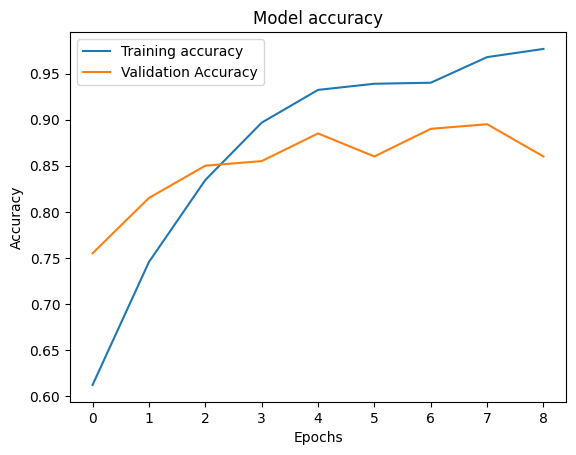

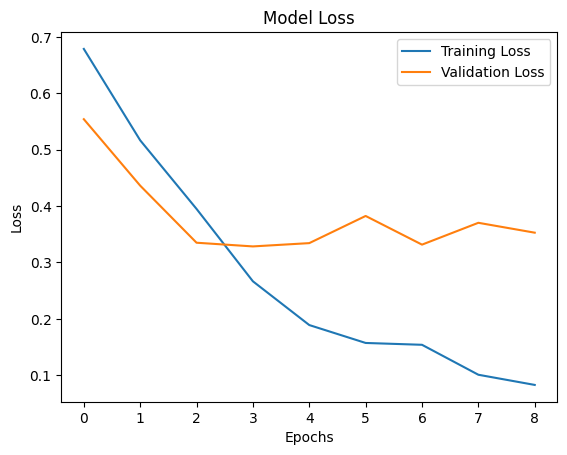

In [37]:
# printing loss and accuracy on test data
results = model.evaluate(X_test_processed,y_test_encoded)
print("Loss = ",results[0])
print("Accuracy = ",results[1]*100,"%")

#plotting training and validation accuracy vs epochs
plt.plot(history.history['binary_accuracy'], label="Training accuracy")
plt.plot(history.history['val_binary_accuracy'], label="Validation Accuracy")
plt.title("Model accuracy")
plt.xlabel("Epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()

#plotting training and validation loss vs epochs
plt.plot(history.history['loss'], label="Training Loss")
plt.plot(history.history['val_loss'], label="Validation Loss")
plt.title("Model Loss")
plt.xlabel("Epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

# **Importing Haar Cascades**

In [57]:
!unzip /content/PIXEL_PERSONA/Final_assignment/240674_NainaBhalla/Dataset/archive.zip

Archive:  /content/PIXEL_PERSONA/Final_assignment/240674_NainaBhalla/Dataset/archive.zip
replace haarcascade_eye.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: 
error:  invalid response [{ENTER}]
replace haarcascade_eye.xml? [y]es, [n]o, [A]ll, [N]one, [r]ename: A
  inflating: haarcascade_eye.xml     
  inflating: haarcascade_eye_tree_eyeglasses.xml  
  inflating: haarcascade_frontalface_alt.xml  
  inflating: haarcascade_frontalface_alt2.xml  
  inflating: haarcascade_frontalface_alt_tree.xml  
  inflating: haarcascade_frontalface_default.xml  
  inflating: haarcascade_fullbody.xml  
  inflating: haarcascade_profileface.xml  
  inflating: haarcascade_smile.xml   
  inflating: haarcascade_upperbody.xml  


# **Final Predictions**

Male                        

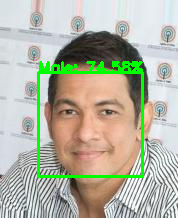

Female                        

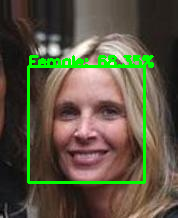

Female                        

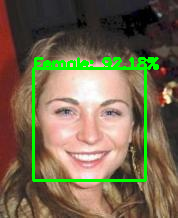

In [29]:
import cv2
import numpy as np
import random
from keras.models import load_model
import matplotlib.pyplot as plt
from google.colab.patches import cv2_imshow

f_cascade = cv2.CascadeClassifier("haarcascade_frontalface_default.xml")  #defining haar cascades for face detection
gender_labels = ["Male", "Female"]

# Function to test the model on random images
def test_model(image):

        image= cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        faces = f_cascade.detectMultiScale(image, 1.3, 5)   #detecting the 4 points in the image using haar cascades
        for idx, f in enumerate(faces):   #using the points
          x,y = f[0], f[1]
          w,h = f[2], f[3]

          # draw rectangle over face
          cv2.rectangle(image, (x,y), (x+w,y+h), (0,255,0), 2)

          # preprocessing for gender detection model
          face_crop = cv2.resize(image, (96,96))
          face_crop = face_crop.astype("float32") / 255.0
          face_crop = np.expand_dims(face_crop, axis=0)

          # apply gender detection on face
          conf = model.predict(face_crop,verbose=0)[0]
          # get label with max accuracy
          idx = np.argmax(conf)
          label = gender_labels[idx]
          if conf[idx] > 0.5:
            label = "Male"
          else:
            label = "Female"
            conf[idx]=1-conf[idx]

          label = "{}: {:.2f}%".format(label, conf[idx] * 100)

          Y = y - 10 if y - 10 > 10 else y + 10

          # write label and confidence above face rectangle
          cv2.putText(image, label, (x,y),  cv2.FONT_HERSHEY_SIMPLEX,0.5, (0, 255, 0), 2)

        # Display or save the processed image
        cv2_imshow(cv2.cvtColor(image, cv2.COLOR_RGB2BGR))

# Test the model on random images
for i in range(3):
  idx = np.random.randint(0, len(X_test_processed))
  full_path = X_test.iloc[idx]
  image=cv2.imread(full_path)
  print(y_test.iloc[idx],end='                        ')
  test_model(image)


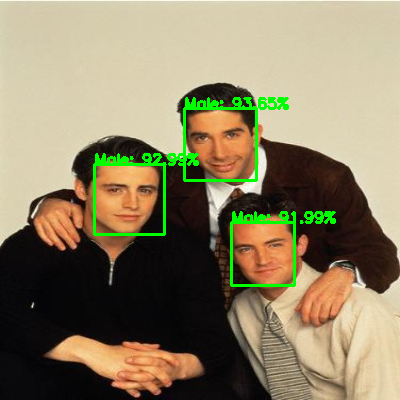

In [62]:
#testing on an image with multiple faces
image=cv2.imread('/content/friends.jpg')
image=cv2.resize(image,(400,400))
test_model(image)

# **Live Model**

**It captures a picture of the person using the webcam and then predicts their gender**


In [51]:
import cv2
from google.colab.patches import cv2_imshow
import IPython
from IPython.display import display,Javascript,Image
from google.colab.output import eval_js
import html
import io
import time
import PIL
from base64 import b64decode, b64encode

In [52]:
# function to convert the JavaScript object into an OpenCV image
def js_to_image(js_reply):
  """
  Params:
          js_reply: JavaScript object containing image from webcam
  Returns:
          img: OpenCV BGR image
  """
  # decode base64 image
  image_bytes = b64decode(js_reply.split(',')[1])
  # convert bytes to numpy array
  jpg_as_np = np.frombuffer(image_bytes, dtype=np.uint8)
  # decode numpy array into OpenCV BGR image
  img = cv2.imdecode(jpg_as_np, flags=1)

  return img

# function to convert OpenCV Rectangle bounding box image into base64 byte string to be overlayed on video stream
def bbox_to_bytes(bbox_array):
  """
  Params:
          bbox_array: Numpy array (pixels) containing rectangle to overlay on video stream.
  Returns:
        bytes: Base64 image byte string
  """
  # convert array into PIL image
  bbox_PIL = PIL.Image.fromarray(bbox_array, 'RGBA')
  iobuf = io.BytesIO()
  # format bbox into png for return
  bbox_PIL.save(iobuf, format='png')
  # format return string
  bbox_bytes = 'data:image/png;base64,{}'.format((str(b64encode(iobuf.getvalue()), 'utf-8')))

  return bbox_bytes

In [53]:
def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
      async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)

  # get photo data
  data = eval_js('takePhoto({})'.format(quality))
  # get OpenCV format image
  img = js_to_image(data)
  test_model(img)
  cv2.imwrite(filename, img)

  return filename

<IPython.core.display.Javascript object>

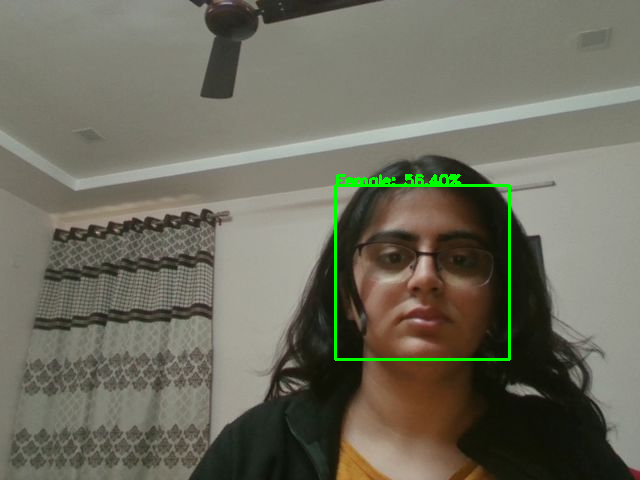

In [57]:
try:
  filename = take_photo('photo.jpg')
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))